FROM KAGGLE: https://www.kaggle.com/datasets/nasa/meteorite-landings

"About data

The Meteoritical Society collects data on meteorites that have fallen to Earth from outer space. This data includes the location, mass, composition, and fall year for over 45,000 meteorites that have struck our planet.

## Notes on missing or incorrect data points:

- a few entries here contain date information that was incorrectly parsed into the NASA database. As a spot check: any date that is before 860 CE or after 2016 are incorrect; these should actually be BCE years. There may be other errors and we are looking for a way to identify them.
- a few entries have latitude and longitude of 0N/0E (off the western coast of Africa, where it would be quite difficult to recover meteorites). Many of these were actually discovered in Antarctica, but exact coordinates were not given. 0N/0E locations should probably be treated as NA.

The Data
Note that a few column names start with "rec" (e.g., recclass, reclat, reclon). These are the recommended values of these variables, according to The Meteoritical Society. In some cases, there were historical reclassification of a meteorite, or small changes in the data on where it was recovered; this data gives the currently recommended values.

## The data contains the following variables:

- name: the name of the meteorite (typically a location, often modified with a number, year, composition, etc)
- id: a unique identifier for the meteorite
- nametype: one of:
    - valid: a typical meteorite
    - relict: a meteorite that has been highly degraded by weather on Earth
- recclass: the class of the meteorite; one of a large number of classes based on physical, chemical, and other characteristics (see the Wikipedia article on meteorite classification for a primer)
- mass: the mass of the meteorite, in grams
- fall: whether the meteorite was seen falling, or was discovered after its impact; one of:
    - Fell: the meteorite's fall was observed
    - Found: the meteorite's fall was not observed
- year: the year the meteorite fell, or the year it was found (depending on the value of fell)
- reclat: the latitude of the meteorite's landing
- reclong: the longitude of the meteorite's landing
- GeoLocation: a parentheses-enclose, comma-separated tuple that combines reclat and reclong"

In [1]:
import pandas as pd
import sklearn
import numpy as np

In [2]:
import mlflow
mlflow.autolog()

2023/08/24 21:21:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
df = pd.DataFrame(pd.read_csv("Meteorite_Landings.csv"))

In [4]:
df.describe()

,id,mass (g),year,reclat,reclong
count,45716.000000,4.558500e+04,45425.000000,38401.000000,38401.000000
mean,26889.735104,1.327808e+04,1991.828817,-39.122580,61.074319
std,16860.683030,5.749889e+05,25.052766,46.378511,80.647298
min,1.000000,0.000000e+00,860.000000,-87.366670,-165.433330
25%,12688.750000,7.200000e+00,1987.000000,-76.714240,0.000000
50%,24261.500000,3.260000e+01,1998.000000,-71.500000,35.666670
75%,40656.750000,2.026000e+02,2003.000000,0.000000,157.166670
max,57458.000000,6.000000e+07,2101.000000,81.166670,354.473330


In [5]:
df.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1.0,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2.0,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6.0,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10.0,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370.0,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"


In [6]:
df.isnull().sum()

name              0
id                1
nametype          1
recclass          1
mass (g)        132
fall              1
year            292
reclat         7316
reclong        7316
GeoLocation    7316
dtype: int64

In [7]:
df = df.dropna()
df.shape

(38115, 10)

Because of the restrictions described in the introduction:

In [8]:
df = df[(df.year >= 860) & (df.year <= 2016)]
df = df[((df.reclong <= 180) & (df.reclong >= -180))
    & ((df.reclat != 0) | (df.reclong != 0))]

In [9]:
df.rename(columns={
        "name": "Name",
        "id": "Id",
        "nametype": "Name_type",
        "Class": "Class",
        "mass (g)": "Mass",
        "fall": "Fall",
        "year": "Year",
        "reclat": "Latitude",
        "reclong": "Longitude",
        "GeoLocation": "Geo_Location",
    },
    inplace=True,)

In [10]:
df.head(10)

,Name,Id,Name_type,recclass,Mass,Fall,Year,Latitude,Longitude,Geo_Location
0,Aachen,1.0,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2.0,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6.0,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10.0,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370.0,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"
5,Adhi Kot,379.0,Valid,EH4,4239.0,Fell,1919.0,32.10000,71.80000,"(32.1, 71.8)"
6,Adzhi-Bogdo (stone),390.0,Valid,LL3-6,910.0,Fell,1949.0,44.83333,95.16667,"(44.83333, 95.16667)"
7,Agen,392.0,Valid,H5,30000.0,Fell,1814.0,44.21667,0.61667,"(44.21667, 0.61667)"
8,Aguada,398.0,Valid,L6,1620.0,Fell,1930.0,-31.60000,-65.23333,"(-31.6, -65.23333)"
9,Aguila Blanca,417.0,Valid,L,1440.0,Fell,1920.0,-30.86667,-64.55000,"(-30.86667, -64.55)"


Text(0.5, 1.0, 'Distribution by "Fall" through time')

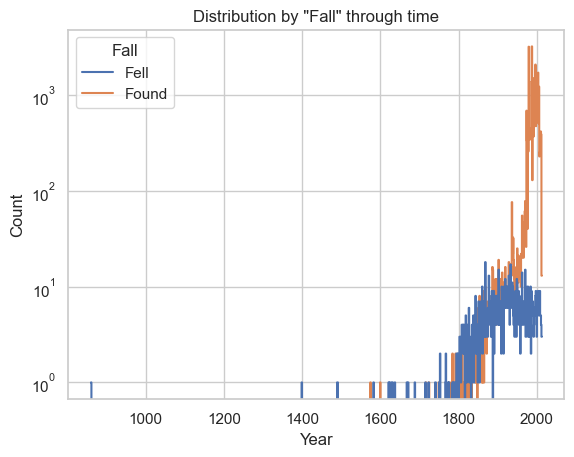

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.histplot(
    data=df, x=df.Year, hue=df.Fall, log_scale=(False, True), element="step", fill=False
)
plt.title('Distribution by "Fall" through time')

In [12]:
df[df.Year < 1000]

,Name,Id,Name_type,recclass,Mass,Fall,Year,Latitude,Longitude,Geo_Location
704,Nogata,16988.0,Valid,L6,472.0,Fell,860.0,33.725,130.75,"(33.725, 130.75)"


<Axes: xlabel='Year', ylabel='Mass'>

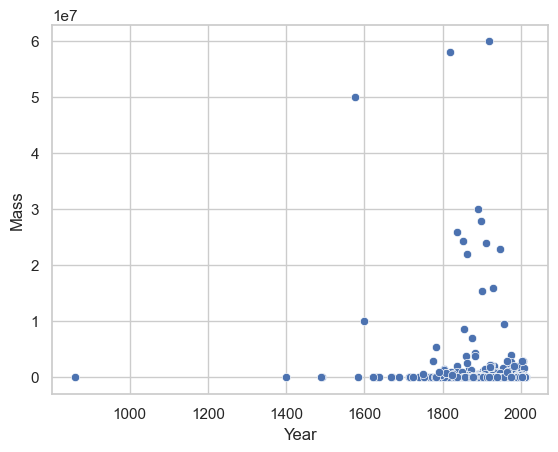

In [13]:
sns.scatterplot(data=df, x=df.Year, y=df.Mass)

## Masses of meteorites are usually small so log scale is a more appropriate choice for visualizing their distribution:

/Users/Bartek/Desktop/Bartek/Programowanie/Python/Portfolio/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Year', ylabel='Mass'>

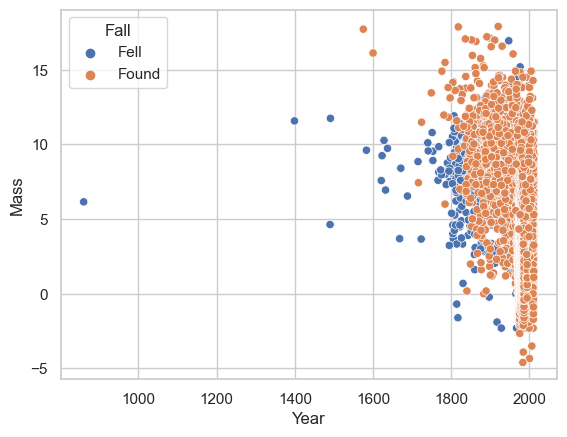

In [14]:
sns.scatterplot(data=df, x=df.Year, y=np.log(df.Mass), hue=df.Fall)

/Users/Bartek/Desktop/Bartek/Programowanie/Python/Portfolio/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Bartek/Desktop/Bartek/Programowanie/Python/Portfolio/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


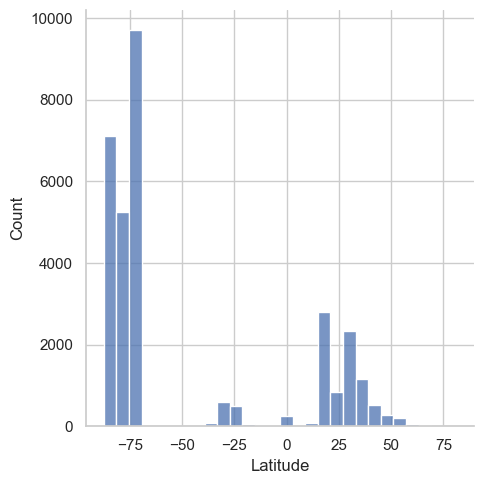

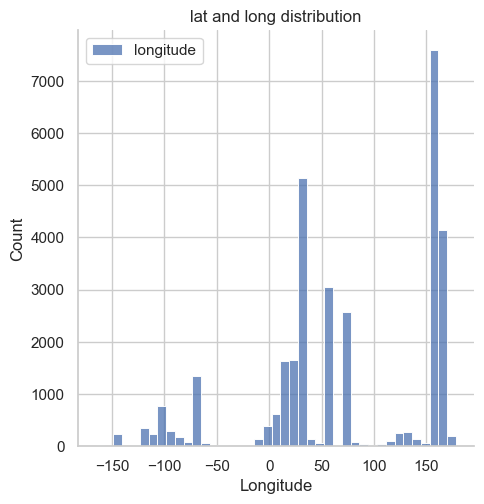

In [15]:
sns.displot(df.Latitude)
sns.displot(df.Longitude)
plt.title("lat and long distribution")
plt.legend(["longitude", "latitude"])

In [16]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
from geopy.point import Point

geolocator = Nominatim(user_agent="meteor")
reverse = partial(geolocator.reverse, language="en")

In [17]:
df.Geo_Location.head(10)

0       (50.775, 6.08333)
1    (56.18333, 10.23333)
2      (54.21667, -113.0)
3       (16.88333, -99.9)
4     (-33.16667, -64.95)
5            (32.1, 71.8)
6    (44.83333, 95.16667)
7     (44.21667, 0.61667)
8      (-31.6, -65.23333)
9     (-30.86667, -64.55)
Name: Geo_Location, dtype: object

In [18]:
# df["State"] = -1
# df["Country"] = -1

## Mapping geolocations to countries and states:

In [19]:
# This cell takes around 12 hours to finish which is resulting from OpenStreetMap requests restrictions
#
# with Nominatim(user_agent="meteor", timeout=10) as geolocator:
#     reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)
#     reverse = partial(reverse, language="en-US", zoom=5, addressdetails=False)
#     for row in df.index:
#         if (df.Country[row] == '-1') or (df.State[row] == '-1'):
#             try:
#                 address_string = reverse(Point(df.Latitude[row], df.Longitude[row])).raw["display_name"].split(", ")
#                 if len(address_string) == 1:
#                     df.loc[row, "Country"] = address_string
#                     df.loc[row, "State"] = address_string
#                 elif len(address_string) == 2:
#                     df.loc[row, "State"], df.loc[row, "Country"] = address_string
#                 elif len(address_string) == 3:
#                     _, df.loc[row, "State"], df.loc[row, "Country"] = address_string
#                 elif len(address_string) > 3:
#                     df.loc[row, "State"], df.loc[row, "Country"] = address_string[-3:-1]
#                 else:
#                     continue
#             except AttributeError:
#                 continue
#         else:
#             continue
# df.to_csv("meteorites_2.csv")

In [20]:
df = pd.read_csv("meteorites.csv")
pd.options.mode.chained_assignment = None  # default='warn'

In [21]:
# Assigning points that are laying beyond the antarctic circle as country "Antarctica"
# and to four seperate parts of the continent depending on the longitude.
df.Country[(df.Latitude < -66.5)] = "Antarctica"
df.State[
    (df.Latitude < -66.5) & (df.Longitude >= 0) & (df.Longitude < 90)
] = "Antarctica I"
df.State[
    (df.Latitude < -66.5) & (df.Longitude >= 90) & (df.Longitude <= 180)
] = "Antarctica II"
df.State[
    (df.Latitude < -66.5) & (df.Longitude < 0) & (df.Longitude >= -90)
] = "Antarctica III"
df.State[
    (df.Latitude < -66.5) & (df.Longitude < -90) & (df.Longitude >= -180)
] = "Antarctica IV"

In [22]:
df.State[df.Country == "Antarctica"].unique()

array(['Antarctica II', 'Antarctica I', 'Antarctica IV', 'Antarctica III'],
      dtype=object)

### manually setting country info for 6 missing entries

In [23]:
df.State.loc[255] = "Sea of Japan"
df.Country.loc[255] = "South Corea"

In [24]:
df.State.loc[577] = "Mauritius"
df.Country.loc[577] = "Mauritius"

In [25]:
df.State.loc[5329] = "North Pacific Ocean"
df.Country.loc[5329] = "Pacific Ocean"

In [26]:
df.State.loc[5338] = "North Pacific Ocean"
df.Country.loc[5338] = "Pacific Ocean"

In [27]:
df.State.loc[10560] = "South Pacific Ocean"
df.Country.loc[10560] = "Pacific Ocean"

In [28]:
df.State.loc[16160] = "Tasmania"
df.Country.loc[16160] = "Australia"

In [29]:
countries_list = df.Country.unique()

In [30]:
countries_list[1]

'Denmark'

In [31]:
import re

re.search("]", "'[Argentina]'")

<re.Match object; span=(11, 12), match=']'>

In [32]:
countries_list = [
    {country: country.strip("'[]'")}
    for country in countries_list
    if re.search("]", country)
]

In [33]:
countries_dict = {}
for country in range(len(countries_list)):
    for key, value in countries_list[country].items():
        countries_dict[key] = value

In [34]:
countries_dict

{}

In [35]:
df.replace({"Country": countries_dict}, inplace=True)

In [36]:
len(df["Country"].unique())

124

In [37]:
df.to_csv("meteorites.csv", index=False)

<Axes: xlabel='Longitude', ylabel='Latitude'>

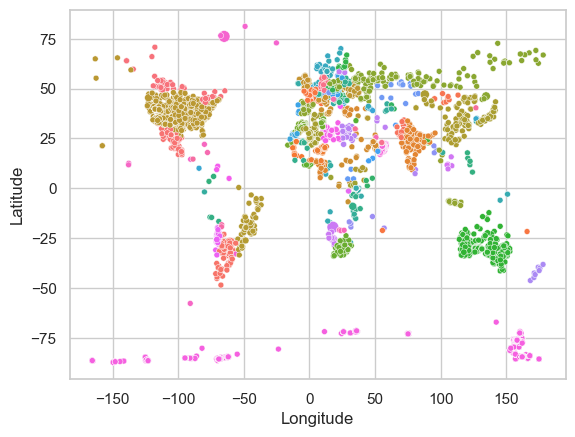

In [38]:
sns.scatterplot(
    x=df.Longitude, y=df.Latitude, hue=df.Country, size=df.Mass, legend=False
)

## Displaying the meteorite landings df on a world map:

In [39]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [40]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]

In [41]:
crs = "epsg:4326"

In [42]:
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)  # coordinate reference system
geo_df.head(10)

,Name,Id,Name_type,Class,Mass,Fall,Year,Latitude,Longitude,Geo_Location,State,Country,geometry
0,Aachen,1.0,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)",North Rhine-Westphalia,Germany,POINT (6.08333 50.77500)
1,Aarhus,2.0,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)",Central Denmark Region,Denmark,POINT (10.23333 56.18333)
2,Abee,6.0,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)",Alberta,Canada,POINT (-113.00000 54.21667)
3,Acapulco,10.0,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)",Guerrero,Mexico,POINT (-99.90000 16.88333)
4,Achiras,370.0,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)",Córdoba,Argentina,POINT (-64.95000 -33.16667)
5,Adhi Kot,379.0,Valid,EH4,4239.0,Fell,1919.0,32.10000,71.80000,"(32.1, 71.8)",Punjab,Pakistan,POINT (71.80000 32.10000)
6,Adzhi-Bogdo (stone),390.0,Valid,LL3-6,910.0,Fell,1949.0,44.83333,95.16667,"(44.83333, 95.16667)",Govi-Altai,Mongolia,POINT (95.16667 44.83333)
7,Agen,392.0,Valid,H5,30000.0,Fell,1814.0,44.21667,0.61667,"(44.21667, 0.61667)",Metropolitan France,France,POINT (0.61667 44.21667)
8,Aguada,398.0,Valid,L6,1620.0,Fell,1930.0,-31.60000,-65.23333,"(-31.6, -65.23333)",Córdoba,Argentina,POINT (-65.23333 -31.60000)
9,Aguila Blanca,417.0,Valid,L,1440.0,Fell,1920.0,-30.86667,-64.55000,"(-30.86667, -64.55)",Córdoba,Argentina,POINT (-64.55000 -30.86667)


In [43]:
world_map = gpd.read_file("ne_110m_admin_0_countries.shp")

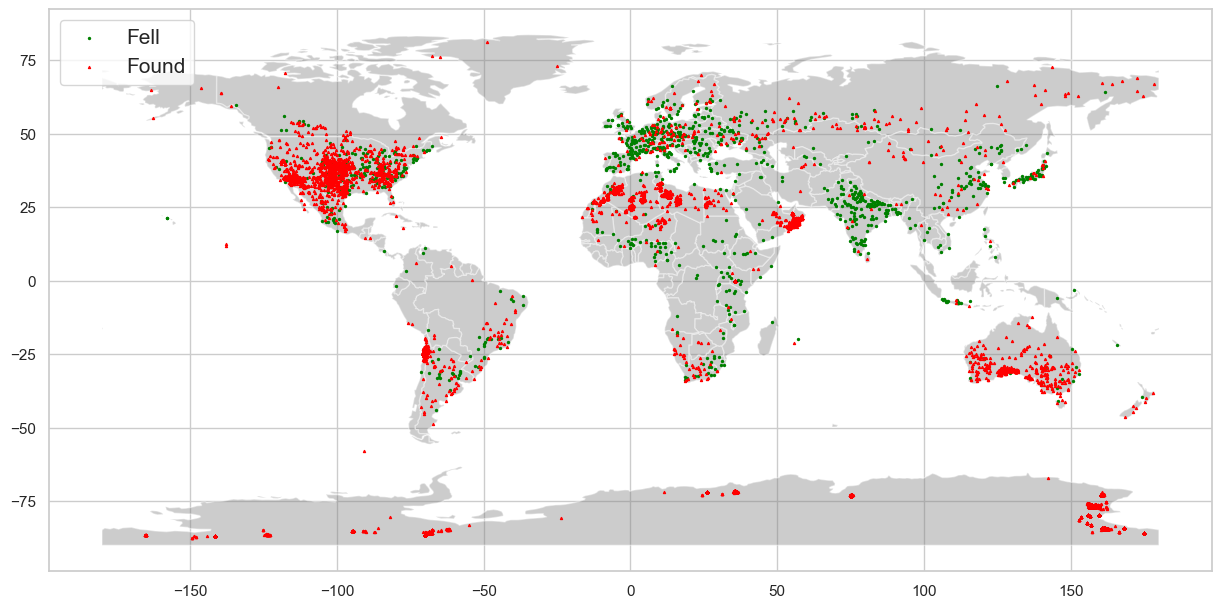

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))
world_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df[geo_df["Fall"] == "Fell"].plot(
    ax=ax, markersize=2, color="green", marker="o", label="Fell"
)
geo_df[geo_df["Fall"] == "Found"].plot(
    ax=ax, markersize=2, color="red", marker="^", label="Found"
)
plt.legend(prop={"size": 15})

In [45]:
df[["Year", "Mass", "Latitude", "Longitude"]].corr()

,Year,Mass,Latitude,Longitude
Year,1.000000,-0.124013,-0.231642,0.198489
Mass,-0.124013,1.000000,0.035906,-0.026956
Latitude,-0.231642,0.035906,1.000000,-0.535199
Longitude,0.198489,-0.026956,-0.535199,1.000000


In [46]:
df[["Year", "Mass", "Latitude", "Longitude"]].cov()

,Year,Mass,Latitude,Longitude
Year,7.139773e+02,-2.276000e+06,-2.891719e+02,4.411922e+02
Mass,-2.276000e+06,4.717622e+11,1.152180e+06,-1.540175e+06
Latitude,-2.891719e+02,1.152180e+06,2.182690e+03,-2.079985e+03
Longitude,4.411922e+02,-1.540175e+06,-2.079985e+03,6.919864e+03


In [47]:
df.duplicated().sum()

0

In [48]:
df["Class"].value_counts()

Class
L6                6523
H5                5586
H4                3324
H6                3231
L5                2723
                  ... 
Martian (OPX)        1
LL7(?)               1
LL6(?)               1
H3.5-4               1
Mesosiderite-C       1
Name: count, Length: 392, dtype: int64

There are almost 400 different classes of meteorites!
Therefore, there is a need to reduce the number of classes and bind them together

In [49]:
df.Class.replace(
    to_replace=[
        "Acapulcoite",
        "Acapulcoite/Lodranite",
        "Acapulcoite/lodranite",
        "Lodranite",
        "Lodranite-an",
        "Winonaite",
        "Achondrite-prim",
    ],
    value="PA",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "Angrite",
        "Aubrite",
        "Aubrite-an",
        "Ureilite",
        "Ureilite-an",
        "Ureilite-pmict",
        "Brachinite",
        "Diogenite",
        "Diogenite-an",
        "Diogenite-olivine",
        "Diogenite-pm",
        "Eucrite",
        "Eucrite-Mg rich",
        "Eucrite-an",
        "Eucrite-br",
        "Eucrite-cm",
        "Eucrite-mmict",
        "Eucrite-pmict",
        "Eucrite-unbr",
        "Howardite",
    ],
    value="AA",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "Lunar",
        "Lunar (anorth)",
        "Lunar (bas. breccia)",
        "Lunar (bas/anor)",
        "Lunar (bas/gab brec)",
        "Lunar (basalt)",
        "Lunar (feldsp. breccia)",
        "Lunar (gabbro)",
        "Lunar (norite)",
    ],
    value="L",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "Martian",
        "Martian (OPX)",
        "Martian (chassignite)",
        "Martian (nakhlite)",
        "Martian (shergottite)",
        "Martian (basaltic breccia)",
    ],
    value="M",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "C",
        "C2",
        "C4",
        "C4/5",
        "C6",
        "C1-ung",
        "C1/2-ung",
        "C2-ung",
        "C3-ung",
        "C3/4-ung",
        "C4-ung",
        "C5/6-ung",
        "CB",
        "CBa",
        "CBb",
        "CH/CBb",
        "CH3",
        "CH3 ",
        "CI1",
        "CK",
        "CK3",
        "CK3-an",
        "CK3.8",
        "CK3/4",
        "CK4",
        "CK4-an",
        "CK4/5",
        "CK5",
        "CK5/6",
        "CK6",
        "CM",
        "CM-an",
        "CM1",
        "CM1/2",
        "CM2",
        "CM2-an",
        "CO3",
        "CO3 ",
        "CO3.0",
        "CO3.1",
        "CO3.2",
        "CO3.3",
        "CO3.4",
        "CO3.5",
        "CO3.6",
        "CO3.7",
        "CO3.8",
        "CR",
        "CR-an",
        "CR1",
        "CR2",
        "CR2-an",
        "CV2",
        "CV3",
        "CV3-an",
        "CR7",
    ],
    value="CC",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "OC",
        "OC3",
        "H",
        "H(5?)",
        "H(?)4",
        "H(L)3",
        "H(L)3-an",
        "H-an",
        "H-imp melt",
        "H-melt rock",
        "H-metal",
        "H/L3",
        "H/L3-4",
        "H/L3.5",
        "H/L3.6",
        "H/L3.7",
        "H/L3.9",
        "H/L4",
        "H/L4-5",
        "H/L4/5",
        "H/L5",
        "H/L6",
        "H/L6-melt rock",
        "H/L~4",
        "H3",
        "H3 ",
        "H3-4",
        "H3-5",
        "H3-6",
        "H3-an",
        "H3.0",
        "H3.0-3.4",
        "H3.1",
        "H3.10",
        "H3.2",
        "H3.2-3.7",
        "H3.2-6",
        "H3.2-an",
        "H3.3",
        "H3.4",
        "H3.4-5",
        "H3.4/3.5",
        "H3.5",
        "H3.5-4",
        "H3.6",
        "H3.6-6",
        "H3.7",
        "H3.7-5",
        "H3.7-6",
        "H3.7/3.8",
        "H3.8",
        "H3.8-4",
        "H3.8-5",
        "H3.8-6",
        "H3.8-an",
        "H3.8/3.9",
        "H3.8/4",
        "H3.9",
        "H3.9-5",
        "H3.9-6",
        "H3.9/4",
        "H3/4",
        "H4",
        "H4 ",
        "H4(?)",
        "H4-5",
        "H4-6",
        "H4-an",
        "H4/5",
        "H4/6",
        "H5",
        "H5 ",
        "H5-6",
        "H5-7",
        "H5-an",
        "H5-melt breccia",
        "H5/6",
        "H6",
        "H6 ",
        "H6-melt breccia",
        "H6/7",
        "H7",
        "H?",
        "H~4",
        "H~4/5",
        "H~5",
        "H~6",
        "L",
        "L(?)3",
        "L(H)3",
        "L(LL)3",
        "L(LL)3.05",
        "L(LL)3.5-3.7",
        "L(LL)5",
        "L(LL)6",
        "L(LL)~4",
        "L-imp melt",
        "L-melt breccia",
        "L-melt rock",
        "L-metal",
        "L/LL",
        "L/LL(?)3",
        "L/LL-melt rock",
        "L/LL3",
        "L/LL3-5",
        "L/LL3-6",
        "L/LL3.10",
        "L/LL3.2",
        "L/LL3.4",
        "L/LL3.5",
        "L/LL3.6/3.7",
        "L/LL4",
        "L/LL4-6",
        "L/LL4/5",
        "L/LL5",
        "L/LL5-6",
        "L/LL5/6",
        "L/LL6",
        "L/LL6-an",
        "L/LL~4",
        "L/LL~5",
        "L/LL~6",
        "L3",
        "L3-4",
        "L3-5",
        "L3-6",
        "L3-7",
        "L3.0",
        "L3.0-3.7",
        "L3.0-3.9",
        "L3.05",
        "L3.1",
        "L3.10",
        "L3.2",
        "L3.2-3.5",
        "L3.2-3.6",
        "L3.3",
        "L3.3-3.5",
        "L3.3-3.6",
        "L3.3-3.7",
        "L3.4",
        "L3.4-3.7",
        "L3.5",
        "L3.5-3.7",
        "L3.5-3.8",
        "L3.5-3.9",
        "L3.5-5",
        "L3.6",
        "L3.6-4",
        "L3.7",
        "L3.7-3.9",
        "L3.7-4",
        "L3.7-6",
        "L3.7/3.8",
        "L3.8",
        "L3.8-5",
        "L3.8-6",
        "L3.8-an",
        "L3.9",
        "L3.9-5",
        "L3.9-6",
        "L3.9/4",
        "L3/4",
        "L4",
        "L4 ",
        "L4-5",
        "L4-6",
        "L4-an",
        "L4-melt rock",
        "L4/5",
        "L5",
        "L5 ",
        "L5-6",
        "L5-7",
        "L5/6",
        "L6",
        "L6 ",
        "L6-melt breccia",
        "L6-melt rock",
        "L6/7",
        "L7",
        "LL",
        "LL(L)3",
        "LL-melt rock",
        "LL3",
        "LL3-4",
        "LL3-5",
        "LL3-6",
        "LL3.0",
        "LL3.00",
        "LL3.1",
        "LL3.1-3.5",
        "LL3.10",
        "LL3.15",
        "LL3.2",
        "LL3.3",
        "LL3.4",
        "LL3.5",
        "LL3.6",
        "LL3.7",
        "LL3.7-6",
        "LL3.8",
        "LL3.8-6",
        "LL3.9",
        "LL3.9/4",
        "LL3/4",
        "LL4",
        "LL4-5",
        "LL4-6",
        "LL4/5",
        "LL4/6",
        "LL5",
        "LL5-6",
        "LL5-7",
        "LL5/6",
        "LL6",
        "LL6 ",
        "LL6(?)",
        "LL6/7",
        "LL7",
        "LL7(?)",
        "LL<3.5",
        "LL~3",
        "LL~4",
        "LL~4/5",
        "LL~5",
        "LL~6",
        "L~3",
        "L~4",
        "L~5",
        "L~6",
        "Relict H",
        "Relict OC",
        "LL-melt breccia",
        "H-melt breccia",
        "L5-melt breccia",
        "LL-imp melt",
        "H3.05",
        "LL6-melt breccia",
        "LL3.05",
        "H4-melt breccia",
        "LL3.8-4",
        "L3.00",
        "L~4-6",
        "LL6-an",
        "L4-melt breccia",
        "LL(L)3.1",
        "L3-melt breccia",
        "H3.15",
    ],
    value="OC",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "EH",
        "EH-imp melt",
        "EH3",
        "EH3/4-an",
        "EH4",
        "EH4/5",
        "EH5",
        "EH6",
        "EH6-an",
        "EH7",
        "EH7-an",
        "EL3",
        "EL3/4",
        "EL4",
        "EL4/5",
        "EL5",
        "EL6",
        "EL6 ",
        "EL6/7",
        "EL7",
        "E",
        "E3",
        "E4",
        "E5",
        "E6",
        "EL-melt rock",
    ],
    value="EC",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "K",
        "K3",
        "R",
        "R3",
        "R3-4",
        "R3-5",
        "R3-6",
        "R3.4",
        "R3.5-6",
        "R3.6",
        "R3.7",
        "R3.8",
        "R3.8-5",
        "R3.8-6",
        "R3.9",
        "R3/4",
        "R4",
        "R4/5",
        "R5",
        "R6",
        "R3.5-4",
    ],
    value="AOC",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "Pallasite",
        "Pallasite, PES",
        "Pallasite, PMG",
        "Pallasite, PMG-an",
        "Pallasite, ungrouped",
        "Pallasite?",
    ],
    value="P",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "Mesosiderite",
        "Mesosiderite-A",
        "Mesosiderite-A1",
        "Mesosiderite-A2",
        "Mesosiderite-A3",
        "Mesosiderite-A3/4",
        "Mesosiderite-A4",
        "Mesosiderite-B",
        "Mesosiderite-B1",
        "Mesosiderite-B2",
        "Mesosiderite-B4",
        "Mesosiderite-C",
        "Mesosiderite-C2",
        "Mesosiderite-an",
        "Mesosiderite?",
    ],
    value="MG",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "Iron, IC",
        "Iron, IC-an",
        "Iron, IIAB",
        "Iron, IIAB-an",
        "Iron, IIC",
        "Iron, IID",
        "Iron, IID-an",
        "Iron, IIF",
        "Iron, IIG",
        "Iron, IIIAB",
        "Iron, IIIAB-an",
        "Iron, IIIAB?",
        "Iron, IIIE",
        "Iron, IIIE-an",
        "Iron, IIIF",
        "Iron, IVA",
        "Iron, IVA-an",
        "Iron, IVB",
    ],
    value="MIM",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "Iron, IAB complex",
        "Iron, IAB-MG",
        "Iron, IAB-an",
        "Iron, IAB-sHH",
        "Iron, IAB-sHL",
        "Iron, IAB-sLH",
        "Iron, IAB-sLL",
        "Iron, IAB-sLM",
        "Iron, IAB-ung",
        "Iron, IAB?",
        "Iron, IIE",
        "Iron, IIE-an",
        "Iron, IIE?",
    ],
    value="NMIM",
    inplace=True,
)

df.Class.replace(
    to_replace=[
        "Iron",
        "Iron?",
        "Relict iron",
        "Chondrite-fusion crust",
        "Fusion crust",
        "Impact melt breccia",
        "Enst achon-ung",
        "Iron, ungrouped",
        "Stone-uncl",
        "Stone-ung",
        "Unknown",
        "Achondrite-ung",
        "Chondrite-ung",
        "Enst achon",
        "E-an",
        "E3-an",
        "E5-an",
        "Howardite-an",
        "C3.0-ung",
        "Iron, IAB-sHL-an",
    ],
    value="UN",
    inplace=True,
)


cell copied from: https://www.kaggle.com/code/brsdincer/meteorite-landings-analysis-all-eda-theory?scriptVersionId=67464335&cellId=30

In [50]:
df["Class"].value_counts()

Class
OC      28570
AA        829
CC        825
MIM       532
EC        385
UN        235
NMIM      228
MG        121
P          64
PA         58
M          44
AOC        38
Name: count, dtype: int64

In [51]:
numerical_attributes = ["Mass", "Year"]
categorical_attributes = ["Name_type", "Class", "State", "Country"] 
# Fall is excluded since it is the independent variable that we want to model

In [52]:
for column in categorical_attributes:
    df[column] = pd.Categorical(df[column])

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31929 entries, 0 to 31928
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Name          31929 non-null  object  
 1   Id            31929 non-null  float64 
 2   Name_type     31929 non-null  category
 3   Class         31929 non-null  category
 4   Mass          31929 non-null  float64 
 5   Fall          31929 non-null  object  
 6   Year          31929 non-null  float64 
 7   Latitude      31929 non-null  float64 
 8   Longitude     31929 non-null  float64 
 9   Geo_Location  31929 non-null  object  
 10  State         31929 non-null  category
 11  Country       31929 non-null  category
dtypes: category(4), float64(5), object(3)
memory usage: 2.1+ MB


In [54]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [55]:
# splitting labels from attributes
x_train = train_set.drop("Fall", axis=1)
y_train = train_set["Fall"].copy()

# splitting labels from attributes
x_test = test_set.drop("Fall", axis=1)
y_test = test_set["Fall"].copy()

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

numerical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("standard_scaler", StandardScaler()),
    ]
)

full_pipeline = ColumnTransformer(
    [
        ("numerical", numerical_pipeline, numerical_attributes),
        ("categorical", OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_attributes),
    ]
)

In [57]:
x_train_prepared = full_pipeline.fit_transform(x_train)
x_train_prepared

2023/08/24 21:21:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a642f06b52df4edb891e9b91d4b8b670', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/24 21:21:48 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/08/24 21:21:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/08/24 21:21:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/Bartek/Desktop/Bartek/Programowanie/Python/Portfolio/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


<25543x673 sparse matrix of type '<class 'numpy.float64'>'
	with 153258 stored elements in Compressed Sparse Row format>

In [58]:
from sklearn.linear_model import LogisticRegression
log_classifier = LogisticRegression(solver='liblinear')

In [59]:
log_classifier.fit(x_train_prepared, y_train)

2023/08/24 21:21:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '843fe2efd49e42da87209ad59d7bfc9b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/24 21:21:49 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


LogisticRegression(solver='liblinear')

In [60]:
y_predictions = log_classifier.predict(x_train_prepared)
(y_predictions == y_train).sum() / len(y_predictions)

0.9906432290647144

The accuracy score needs to be verified using cross-validation

In [61]:
from sklearn.metrics import confusion_matrix, f1_score

print(confusion_matrix(y_train, y_predictions))
print(f1_score(y_train, y_predictions, average="binary", pos_label="Fell"))

[[  694   170]
 [   69 24610]]
0.8531038721573448


The f1-score suggests that the model is both accurate and robust

In [62]:
from sklearn.model_selection import cross_val_score, cross_val_predict
cross_val_score(log_classifier, x_train_prepared, y_train, cv=5, scoring="accuracy")

array([0.98825602, 0.98825602, 0.98747309, 0.98766641, 0.98414252])

The results of cross validation are actually very good.

In [63]:
from sklearn.metrics import accuracy_score

x_test_prepared = full_pipeline.transform(x_test)

new_predictions = log_classifier.predict(x_test_prepared)
accuracy_score(y_test, new_predictions)

0.9863764484810523

The models accuracy on test set is over 98% which means that the model is very precise.